In [1]:
%matplotlib inline
from CameraNetwork.image_utils import raw2RGB, RGB2raw
import cPickle
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io as sio
import traceback

c:\users\amitibo\documents\code\cameranetwork\CameraNetwork\transformation_matrices.py:1934: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


In [36]:
BASE_PATH = r"C:\Users\amitibo\Documents\code\cameranetwork\scripts_calibrate\vignetting_calibration\4102820396"
#BASE_PATH = r"C:\Users\amitibo\Documents\code\cameranetwork\scripts_calibrate\vignetting_calibration\4102820396"

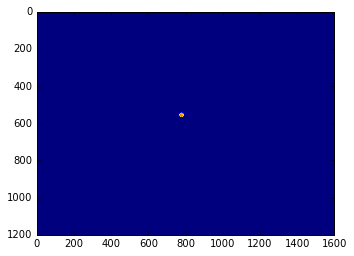

In [41]:
img = sio.loadmat(os.path.join(BASE_PATH, "images/img_300.mat"))["img"]
plt.imshow(img, vmax=255)

In [38]:
with open(os.path.join(BASE_PATH, "measurements.pkl"), "rb") as f:
    color_measurements = cPickle.load(f)

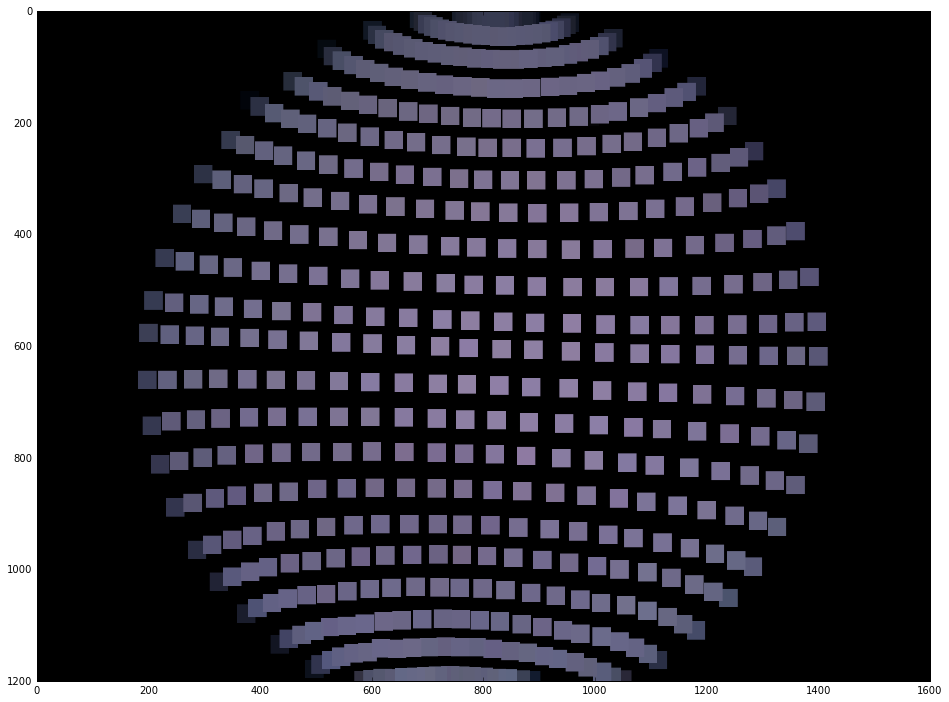

In [43]:
results = np.zeros(shape=(1200, 1600, 3), dtype=np.uint8)

for x, y, val in color_measurements:
    if val is None:
        continue
    results[y, x, :] = np.array(val).astype(np.uint8)
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(results, kernel, iterations = 8)
plt.figure(figsize=(16, 16))
plt.imshow(dilation)

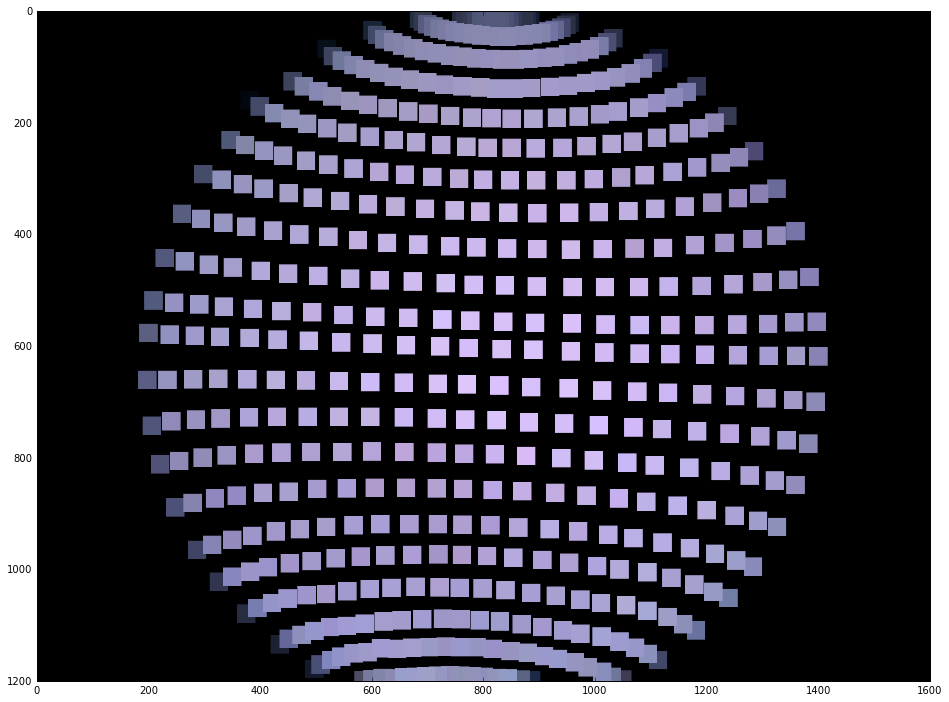

In [46]:
dilation = dilation.astype(np.float32)/dilation.max()

plt.figure(figsize=(16, 16))
plt.imshow(dilation)

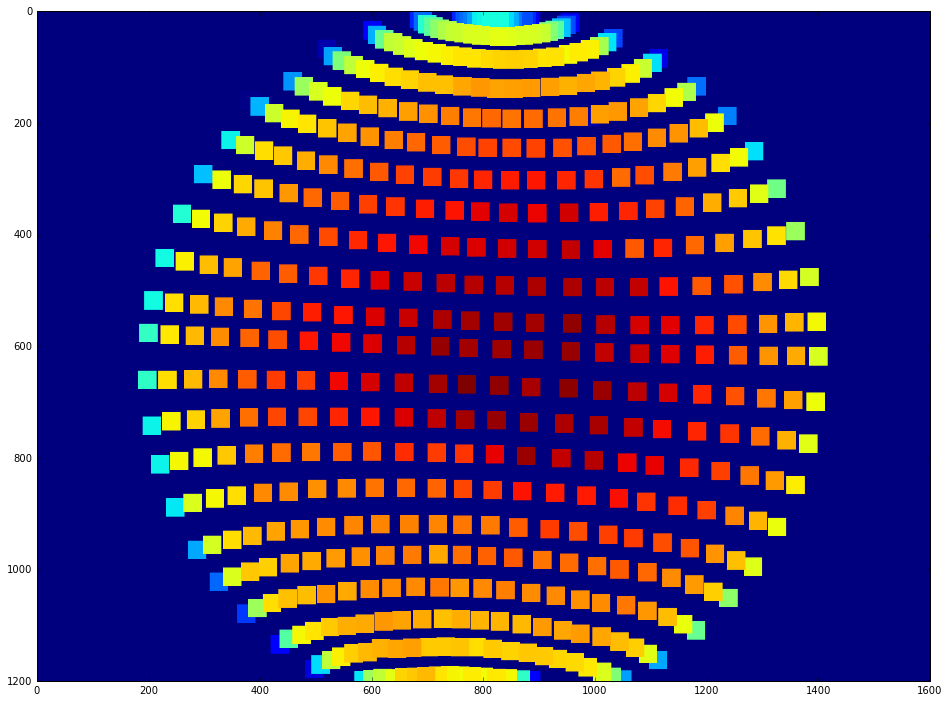

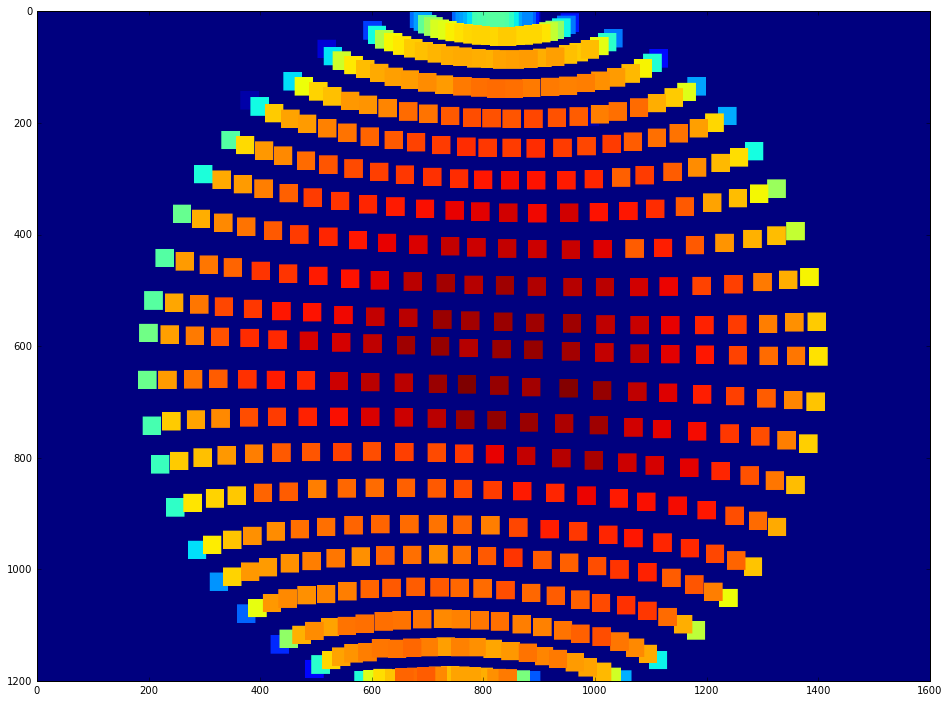

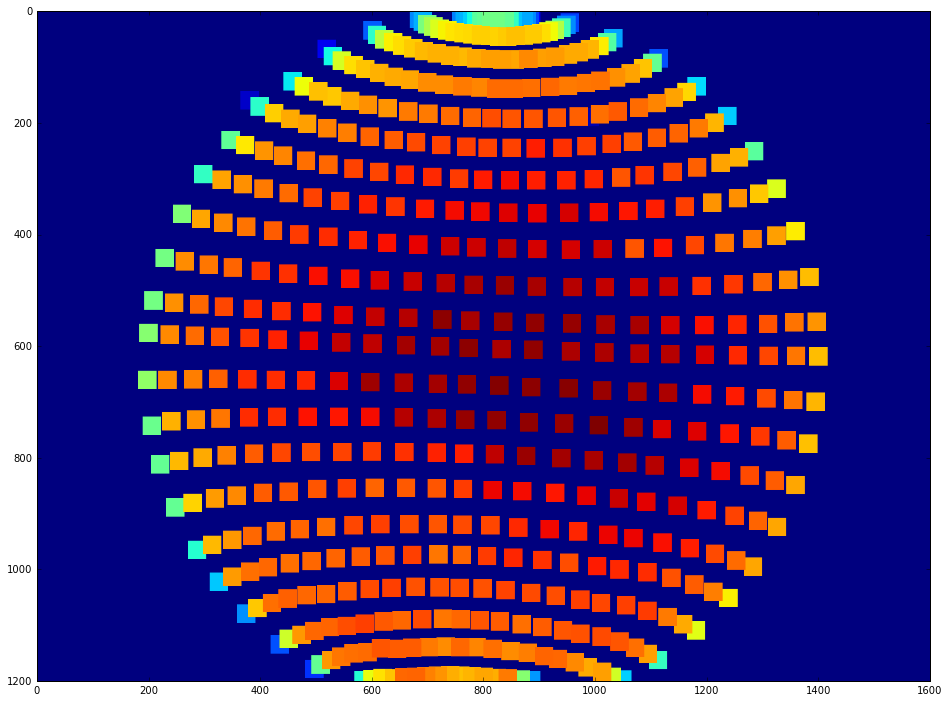

In [40]:
for i in range(3):
    results = np.zeros(shape=(1200, 1600))

    for x, y, val in color_measurements:
        if val is None:
            continue
        results[y, x] = val[i]
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(results, kernel, iterations = 8)
    plt.figure(figsize=(16, 16))
    plt.imshow(dilation)

In [23]:
color_measurements[300]

(775, 555, [141.14999999999998, 126.14358974358976, 161.26642857142855])

In [2]:
with open(r"C:\Users\Public\amit code\cameranetwork_git\scripts_calibrate\vignetting_calibration\4103098526\measurements.pkl", "rb") as f:
    color_measurements = cPickle.load(f)
results = sio.loadmat(r"C:\Users\Public\amit code\cameranetwork_git\scripts_calibrate\vignetting_calibration\4103098526/results.mat")['img']
black_img = np.load(r"C:\Users\Public\amit code\cameranetwork_git\scripts_calibrate\vignetting_calibration\4103098526/black_img.npy")

In [40]:
def meanColor(c):
    """Calculate mean of nnz values in array.

    Args:
        c (array): Array for which to calculate mean.

    Returns:
        Mean of non zero values in c.
    """
    nnz_total = (c>0).sum()
    if nnz_total == 0:
        return 0

    return c.sum()/nnz_total


def findSpot(img, threshold=5):
    """Calculate spot value in image.

    Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments"""

    import cv2

    #
    # Mask threshold
    #
    img = np.dstack(raw2RGB(img))
    img_median = img.max()/2
    if img_median < threshold:
        raise Exception('Median too small: {}'.format(img_median))

    #
    # Calculate a spot mask.
    #
    kernel = np.ones((3, 3),np.uint8)
    mask = (img>threshold)
    mask = cv2.dilate(mask.astype(np.uint8), kernel)
    mask = cv2.erode(mask.astype(np.uint8), kernel, iterations=2)

    #
    # Image values at spot.
    #
    img_filt = img.astype(np.float) * mask
    total = img_filt[..., 0].sum()
    if total == 0:
        raise Exception('Empty Image')

    #
    # Calc the first momentum (center) of the spot
    #
    Y, X = np.indices(img.shape[:2])
    x = (X*img_filt[..., 0]).sum()/total
    y = (Y*img_filt[..., 0]).sum()/total

    return int(x)*2, int(y)*2, [meanColor(c) for c in np.split(img_filt, (1, 2), axis=2)]

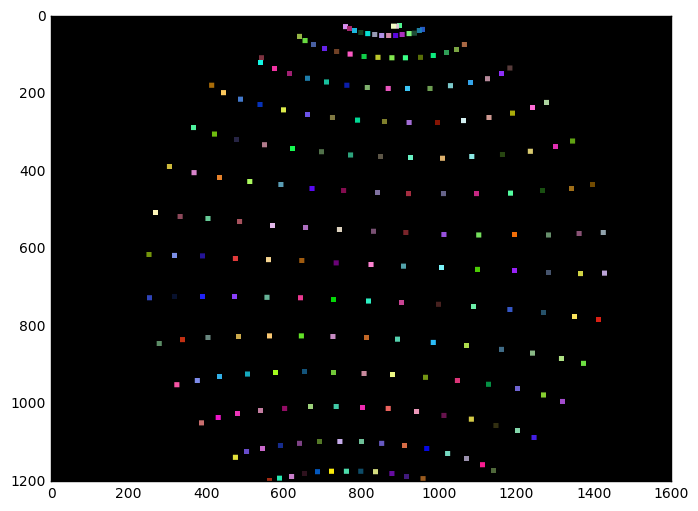

In [30]:
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(results, kernel, iterations = 3)
plt.figure(1, (8, 8))
plt.imshow(dilation)

In [35]:
images_paths = sorted(glob.glob(r"C:\data\vignetting_calibration\4102820388\images\*.mat"))
images = []
for path in images_paths:
    images.append(sio.loadmat(path)['img'])

In [41]:
measurements = []
fail_cnt = 0
for img in images:
    try:
        measurement = findSpot(np.clip(img-black_img, 0, 255))
    except:
        fail_cnt += 1
        #traceback.print_exc()
        measurement = None, None, None

    measurements.append(measurement)
print fail_cnt

55


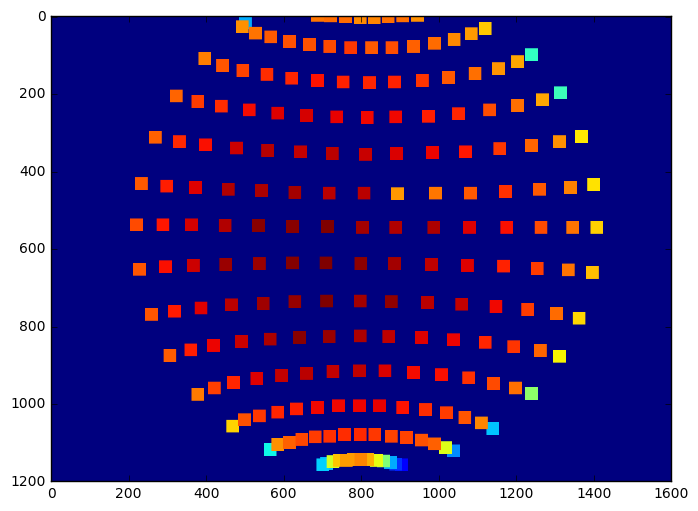

In [45]:
results = np.zeros(shape=(1200, 1600))

for x, y, val in measurements:
    if val is None:
        continue
    results[y, x] = val[2]
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(results, kernel, iterations = 8)
plt.figure(1, (8, 8))
plt.imshow(dilation)